In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Run Segment Anything Model 2 on a live video stream


In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from IPython import display

### Loading the SAM 2 camera predictor


In [3]:
from sam2.build_sam import build_sam2_camera_predictor

sam2_checkpoint = "../checkpoints/sam2_hiera_small.pt"
model_cfg = "sam2_hiera_s.yaml"

predictor = build_sam2_camera_predictor(model_cfg, sam2_checkpoint)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_bbox(bbox, ax, marker_size=200):
    tl, br = bbox[0], bbox[1]
    w, h = (br - tl)[0], (br - tl)[1]
    x, y = tl[0], tl[1]
    print(x, y, w, h)
    ax.add_patch(plt.Rectangle((x, y), w, h, fill=None, edgecolor="blue", linewidth=2))

#### Select an video stream (video or camera)


In [5]:
cap = cv2.VideoCapture("/home/shaol/xzhixuan/Grounded-SAM-2/sav_dataset/example/sav_000001.mp4")
ret, frame = cap.read()
width, height = frame.shape[:2][::-1]

In [6]:
width, height

(480, 848)

In [7]:
frame.shape

(848, 480, 3)

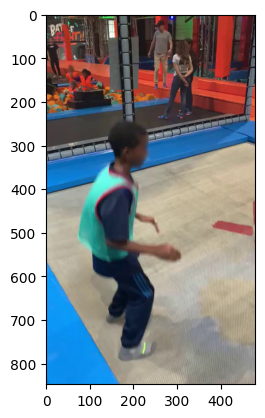

In [8]:
from matplotlib import  pyplot as plt
plt.imshow(frame[:,:,::-1])

In [9]:
frame[:, :, ::-1].shape

(848, 480, 3)

In [10]:
from groundingdino.util.inference import load_model, load_image, predict
from torchvision.ops import box_convert
import groundingdino.datasets.transforms as T
from PIL import Image

GROUNDING_DINO_CONFIG = "/home/shaol/xzhixuan/Grounded-SAM-2/grounding_dino/groundingdino/config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_CHECKPOINT = "/home/shaol/xzhixuan/Grounded-SAM-2/gdino_checkpoints/groundingdino_swint_ogc.pth"
BOX_THRESHOLD = 0.35
TEXT_THRESHOLD = 0.25
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DUMP_JSON_RESULTS = True

# build grounding dino model
grounding_model = load_model(
    model_config_path=GROUNDING_DINO_CONFIG, 
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT,
    device=DEVICE
)

# setup the input image and text prompt for SAM 2 and Grounding DINO
# VERY important: text queries need to be lowercased + end with a dot
TEXT_PROMPT = "black boy jumping."
text = TEXT_PROMPT

transform = T.Compose(
    [
        T.RandomResize([800], max_size=1333),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
image_source = frame[:, :, ::-1]
image_source_img = Image.fromarray(image_source)
image, _ = transform(image_source_img, None)

boxes, confidences, labels = predict(
    model=grounding_model,
    image=image,
    caption=text,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
)

# process the box prompt for SAM 2
h, w, _ = image_source.shape
boxes = boxes * torch.Tensor([w, h, w, h])
input_boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()

final text_encoder_type: bert-base-uncased


In [11]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [12]:
input_boxes

array([[ 70.921486, 243.646   , 311.99338 , 798.3661  ]], dtype=float32)

#### Step 1: Add a first click on the first frame



Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).


IndexError: index 1 is out of bounds for axis 0 with size 1

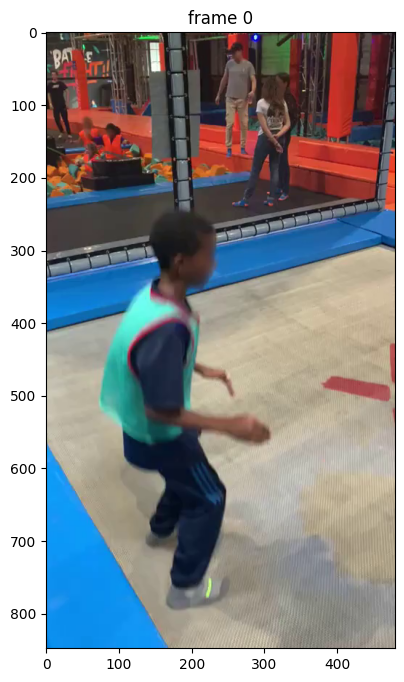

In [13]:
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

predictor.load_first_frame(frame)
if_init = True

using_point = False # if True, we use point prompt, otherwise we use bbox prompt

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = (
    1  # give a unique id to each object we interact with (it can be any integers)
)
# Let's add a positive click at (x, y) = (210, 350) to get started

# using point prompt
# points = np.array([[670, 247]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], dtype=np.int32)
# bbox = np.array([[600, 214], [765, 286]], dtype=np.float32)

plt.figure(figsize=(12, 8))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(frame)

# if using_point:
#     _, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
#         frame_idx=ann_frame_idx,
#         obj_id=ann_obj_id,
#         points=points,
#         labels=labels,
#     )
#     show_points(points, labels, plt.gca())

# else:
_, out_obj_ids, out_mask_logits = predictor.add_new_prompt(
    frame_idx=ann_frame_idx, obj_id=ann_obj_id, bbox=input_boxes.reshape(2, 2)
)


70.921486 243.646 241.0719 554.7201


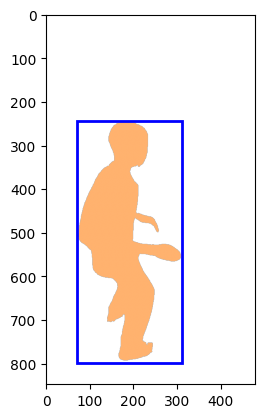

In [14]:
show_bbox(input_boxes.reshape(2, 2), plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

#### Step 2: track


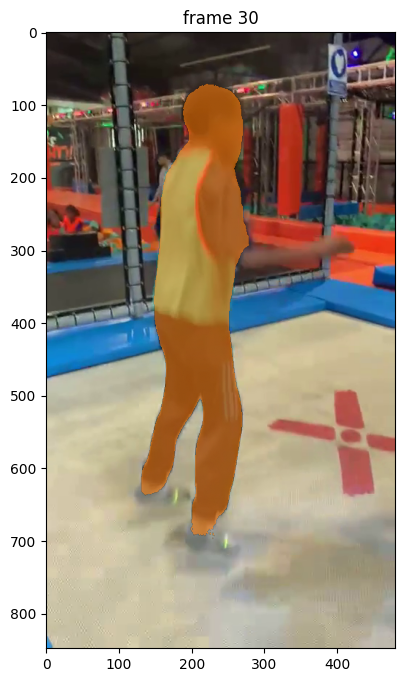

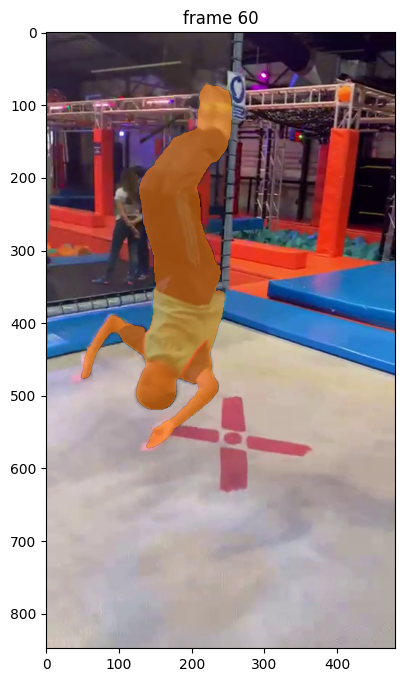

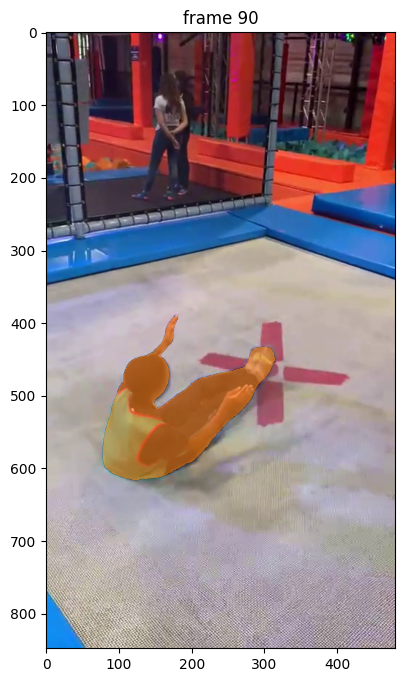

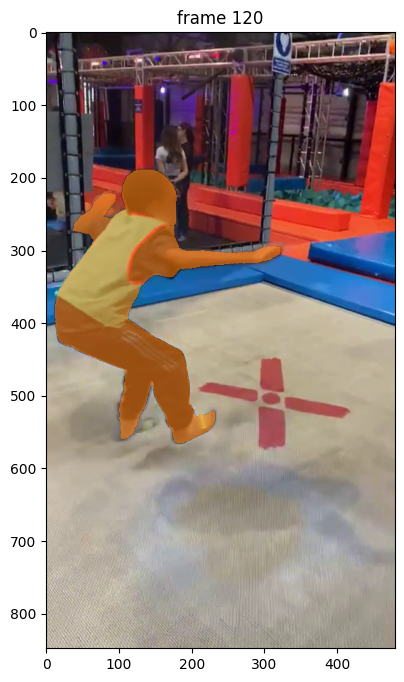

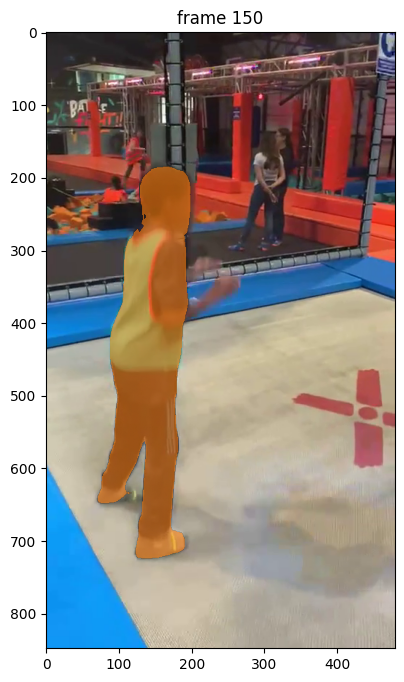

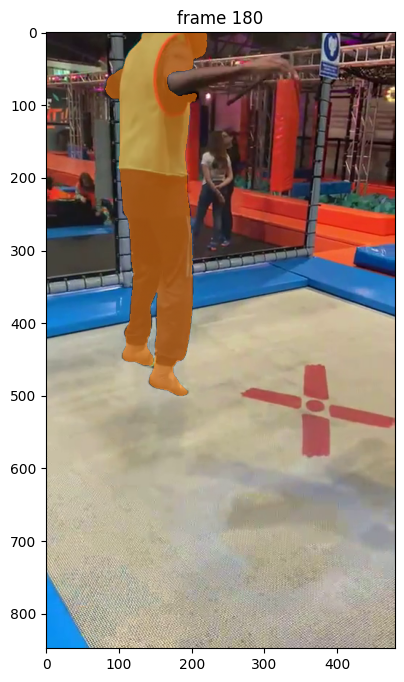

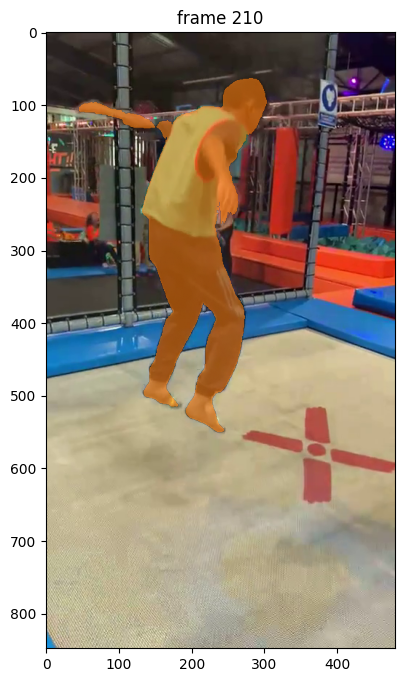

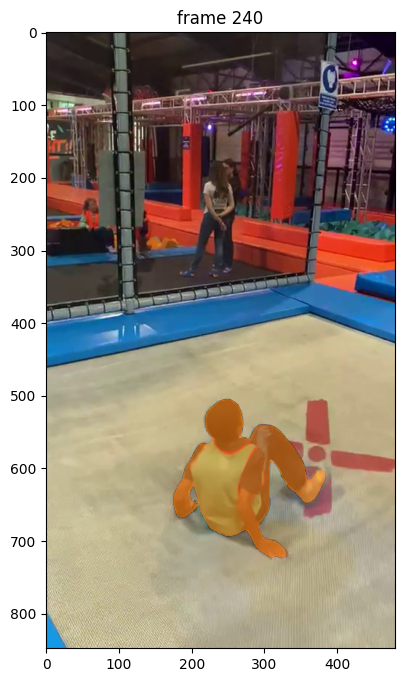

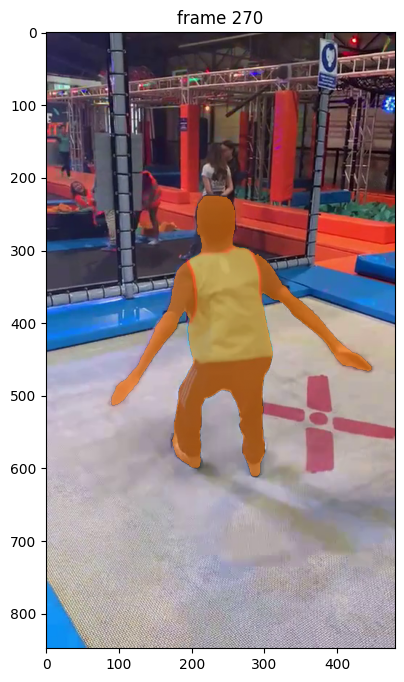

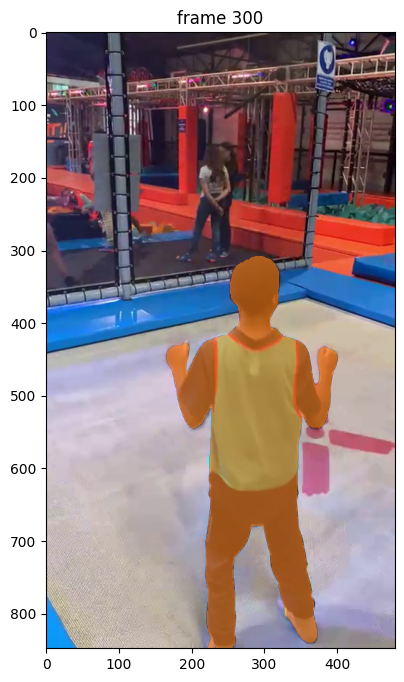

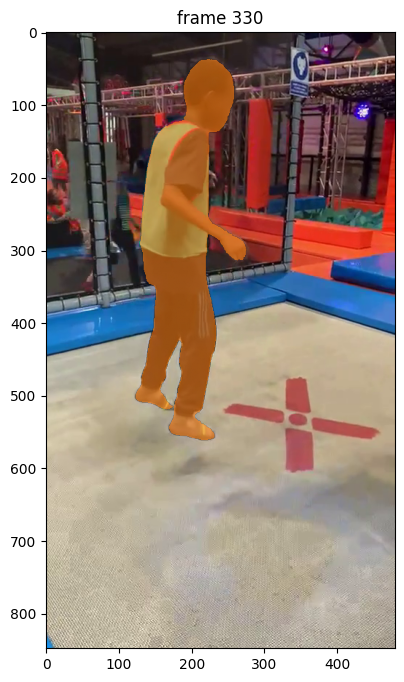

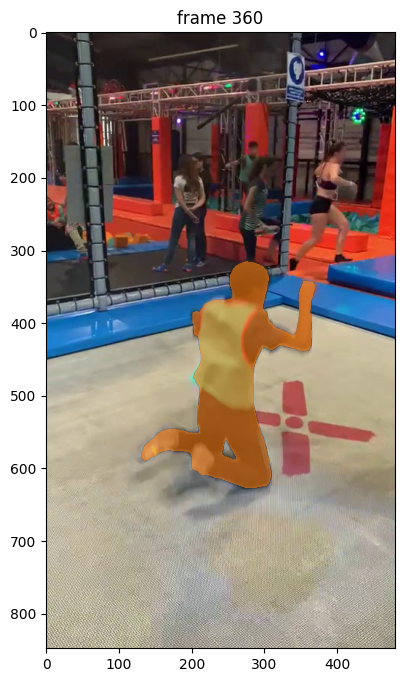

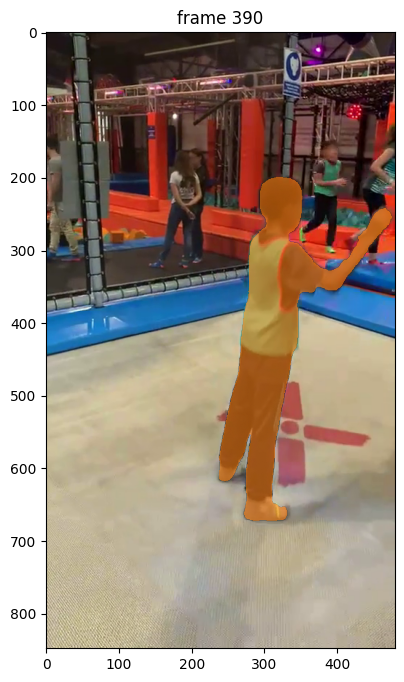

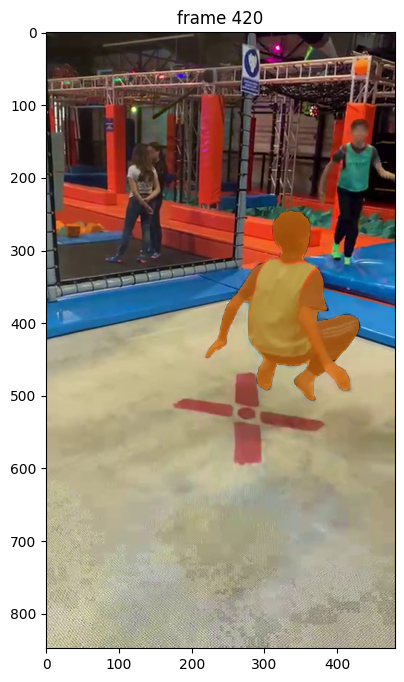

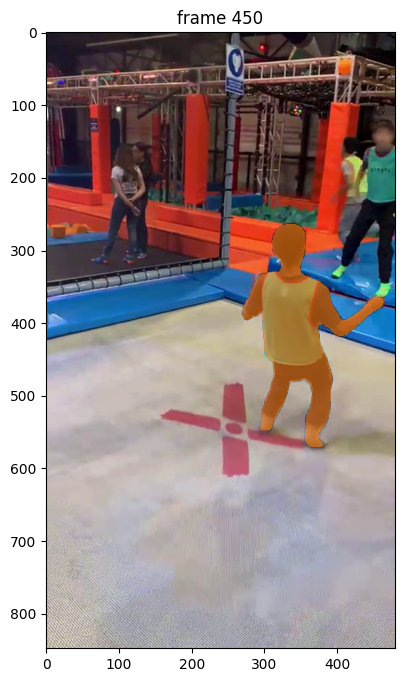

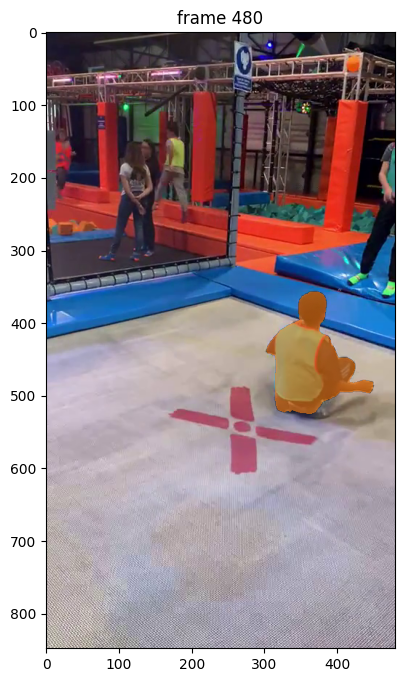

In [15]:
vis_gap = 30

while True:

    ret, frame = cap.read()
    ann_frame_idx += 1
    if not ret:
        break
    width, height = frame.shape[:2][::-1]

    out_obj_ids, out_mask_logits = predictor.track(frame)

    if ann_frame_idx % vis_gap == 0:
        print(f"frame {ann_frame_idx}")
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        display.clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.title(f"frame {ann_frame_idx}")
        plt.imshow(frame)
        show_mask(
            (out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0]
        )

cap.release()